In [119]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import gc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
from time import time
%matplotlib inline

In [91]:
MODEL_PATH = 'model/lgbm_model_allen.pkl'
PROCESSED_TRAIN = 'input/e18d0468-7089-43cf-b38b-7c34096134a4.csv'
PROCESSED_TEST = 'input/8eda5593-be69-4775-8a8f-78fbc32f17e7.csv'
OUTPUT_PATH  = 'output/output.csv'

In [289]:
def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

def rename_column(df):
    df = df.rename(columns={col: col.split(':')[1] for col in df.columns})
    return df

def plot_importance(model_path = MODEL_PATH):
    model = pickle.load(open(model_path))
    lgb.plot_importance(model)
    plt.show()
    
def print_importance(lgb_model):
    # 'Split' contains the number of times a feature is used in prediction
    # 'Gain' contains the total gain from a features used in prediction
    
    split = lgb_model.feature_importance('split')
    gain = lgb_model.feature_importance('gain')
    ft = pd.DataFrame({
        'feature': lgb_model.feature_name(),
        'split': split,
        'gain': 100*gain/gain.sum()
        
    })
    
    print("--- Feature importance with 'gain' measure ---")
    df_gain = ft.sort_values('gain', ascending = False)
    print(df_gain.head(50))
    print('Top 10 features:')
    for feature in df_gain['feature'][:10]:
        print(feature)
        
        
    print("--- Feature importance with 'split' measure---")
    df_split = ft.sort_values('split', ascending=False)
    print(df_split.head(50))
    print('Top 10 features:')
    for feature in df_split['feature'][:10]:
        print(feature)

def train_lgbm_model(params, lgb_train, lgb_val):
    print("Starting to train LightGBM model......")
    print(params) # print parameters
    start = time()
    lgbm_model = lgb.train(params,
                           train_set=lgb_train,
                           valid_sets=lgb_val,
                           verbose_eval=5,
                           num_boost_round=1300,
                           early_stopping_rounds=50)
    
    print("Took {} secs".format(int(time()-start)))
    return lgbm_model

In [263]:
# Reference:
# 1. https://www.dataquest.io/blog/pandas-big-data/
# 2. https://stackoverflow.com/questions/39904889/pandas-cast-all-object-columns-to-category

def compress_df(df):
    d_types = list(df.dtypes.unique())
    for i in d_types:
        if i == 'float64':
            df_float = df.select_dtypes(include=i).apply(pd.to_numeric, downcast='float')
        elif i == 'int64':
            df_int = df.select_dtypes(include=i).apply(pd.to_numeric, downcast='unsigned')
        elif i == 'bool':
            df_bool = df.select_dtypes(include=i)
        elif i == 'object':
            df_obj = df.select_dtypes(include=i).apply(pd.Series.astype, dtype='category')
    
    return pd.concat([df_float, df_int, df_bool, df_obj], axis=1)

In [272]:
def memory_usage(pandas_obj):
    usage_b = pandas_obj.memory_usage(deep=True).sum()
    usage_mb = usage_b / 1024**2
    return "{:.3f} MB".format(usage_mb)

In [284]:
train, test = load_data(PROCESSED_TRAIN, PROCESSED_TEST)

In [285]:
print(memory_usage(train))
print(memory_usage(test))

3971.980 MB
4154.555 MB


In [286]:
# Compress the train and test data
train_compress = compress_df(train)
test_compress = compress_df(test)

In [287]:
print(memory_usage(train_compress))
print(memory_usage(test_compress))

1204.168 MB
1259.171 MB


In [288]:
# Clean up the column names
train_compress = rename_column(train_compress)
test_compress = rename_column(test_compress)

In [291]:
train_compress.columns

Index(['restaurant_rush_created_to_accepted_in_seconds_avg_1week_now',
       'restaurant_rush_begun_to_dropoff_in_seconds_avg_1week_now',
       'restaurant_order_created_to_accepted_in_seconds_avg_1week_now',
       'restaurant_rush_accepted_to_begun_in_seconds_avg_1week_now',
       'restaurant_order_accepted_to_finished_in_seconds_avg_1week_now',
       'restaurant_order_created_to_rush_begun_in_seconds_avg_1week_now',
       'restaurant_order_count_1week_now',
       'restaurant_order_created_to_rush_begun_in_seconds_avg_1week',
       'restaurant_rush_accepted_to_begun_in_seconds_avg_1week',
       'restaurant_rush_created_to_accepted_in_seconds_avg_1week',
       'restaurant_rush_begun_to_dropoff_in_seconds_avg_1week',
       'restaurant_order_created_to_accepted_in_seconds_avg_1week',
       'restaurant_order_accepted_to_finished_in_seconds_avg_1week',
       'restaurant_order_count_1week',
       'nrf__at_rush_arrived__from_rush_began_to_rush_arrived_at_dropoff_avg_10min',
   

In [309]:
train_compress.loc[:,('restaurant_rush_created_to_accepted_in_seconds_avg_1week_now', 
                            'restaurant_rush_begun_to_dropoff_in_seconds_avg_1week_now')].describe()

,restaurant_rush_created_to_accepted_in_seconds_avg_1week_now,restaurant_rush_begun_to_dropoff_in_seconds_avg_1week_now
count,4.181252e+06,4.181252e+06
mean,5.541782e+01,6.657632e+02
std,1.063511e+02,2.773431e+02
min,-2.000000e+01,-2.000000e+01
25%,1.088893e+01,5.342534e+02
50%,2.434132e+01,6.922453e+02
75%,5.881670e+01,8.361024e+02
max,5.349653e+03,7.173553e+03


In [312]:
a = train_compress.loc[:,('restaurant_rush_created_to_accepted_in_seconds_avg_1week_now', 
                            'restaurant_rush_begun_to_dropoff_in_seconds_avg_1week_now')]

In [313]:
a[a<0] = 0

In [314]:
a.describe()

,restaurant_rush_created_to_accepted_in_seconds_avg_1week_now,restaurant_rush_begun_to_dropoff_in_seconds_avg_1week_now
count,4.181252e+06,4.181252e+06
mean,5.661746e+01,6.669631e+02
std,1.056211e+02,2.744085e+02
min,0.000000e+00,0.000000e+00
25%,1.088893e+01,5.342534e+02
50%,2.434132e+01,6.922453e+02
75%,5.881670e+01,8.361024e+02
max,5.349653e+03,7.173553e+03


In [317]:
a.shape

(4181252, 2)

In [331]:
b = pd.DataFrame({'col1':[16.095417], 'col2':[518.676270]})

In [332]:
b

,col1,col2
0,16.095417,518.67627


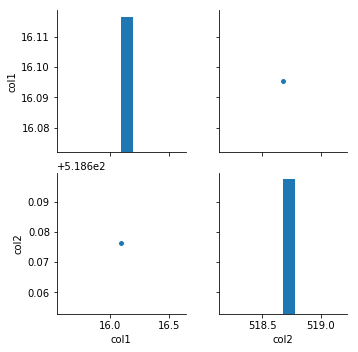

In [333]:
sns.pairplot(b)

In [324]:
a.isna().sum()

restaurant_rush_created_to_accepted_in_seconds_avg_1week_now    0
restaurant_rush_begun_to_dropoff_in_seconds_avg_1week_now       0
dtype: int64

In [338]:
c = a.head(1)

In [339]:
c

,restaurant_rush_created_to_accepted_in_seconds_avg_1week_now,restaurant_rush_begun_to_dropoff_in_seconds_avg_1week_now
0,16.095417,518.67627


In [342]:
c.shape

(1, 2)

In [343]:
c.columns = ['a','b']

In [344]:
c

,a,b
0,16.095417,518.67627


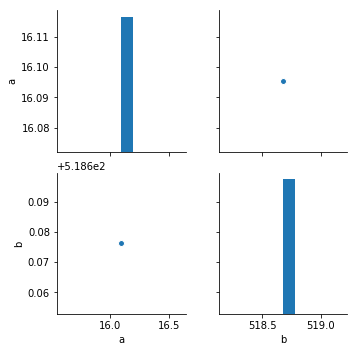

In [345]:
sns.pairplot(c)

In [346]:
train_compress.shape

(4181252, 80)

In [348]:
new_name = []

for i in range(80):
    new_name.append('var_' + str(i+1))

In [350]:
train_compress_plot = train_compress.copy()

In [351]:
train_compress_plot.columns = new_name

In [352]:
train_compress_plot.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80
0,16.095417,518.676270,5.081167,685.831665,-5.569417,731.573486,12.0,763.919128,690.512512,43.788223,...,0.000832,0,False,False,United States,Dallas,Friday,01194ea9-bff6-402b-bab7-6cad12ffaafc,d8fb9d71-d641-43e1-901c-5f36a182c2d9,Burger
1,22.797539,585.246826,29.818153,526.569946,304.557922,667.604980,13.0,663.391846,527.696716,14.019222,...,0.058315,0,False,False,New Zealand,Auckland,Monday,02767cc1-9e13-4ab1-8612-8047abc12cad,NaN,Turkish
2,117.623001,557.911499,48.632500,580.231506,843.990479,1183.734497,2.0,1587.102661,666.384766,403.574371,...,0.040265,0,False,False,Singapore,Singapore,Friday,05811727-e425-4f96-974b-2f13e2c0f4a9,NaN,Burger
3,5.420000,508.494995,11.174000,1124.707031,558.666016,1240.302002,1.0,1046.085083,827.029236,74.579666,...,0.035274,0,False,False,Canada,Toronto,Monday,060afa53-4148-47f6-b416-4754d40ef1e1,f00f59cc-d8d3-414f-ac05-7fed3f78eb72,Italian
4,10.772000,638.982239,20.308750,1377.369263,717.465759,1718.986450,4.0,1289.303467,974.142090,11.587545,...,0.027628,0,False,False,South Africa,Johannesburg and Pretoria,Tuesday,082146ef-b916-4feb-881f-70b9860e613e,eecbb32a-762b-4ef7-9eea-05dcc4e96a64,SouthAfrican


In [386]:
a = train_compress_plot.loc[:,('var_1', 'var_2', 'var_73')].copy()

In [387]:
a['var_73'] = ['Batched' if i else 'Non-Batched' for i in a['var_73']]
a['var_73'] = a['var_73'].astype('category')

In [388]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4181252 entries, 0 to 4181251
Data columns (total 3 columns):
var_1     float32
var_2     float32
var_73    category
dtypes: category(1), float32(2)
memory usage: 35.9 MB


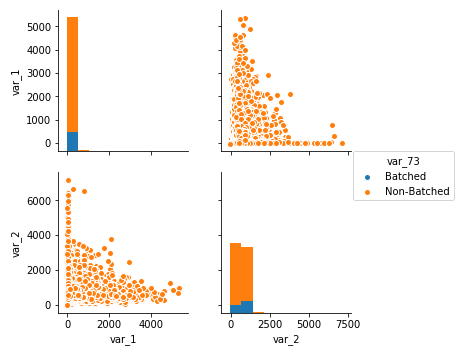

In [389]:
sns.pairplot(a, hue='var_73', palette={'Batched':blue, 'Non-Batched':})

In [355]:
iris = sns.load_dataset("iris")

In [361]:
df.select_dtypes(include=i).apply(pd.Series.astype, dtype='category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [366]:
iris['species'] = iris['species'].astype('category')

In [368]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null category
dtypes: category(1), float64(4)
memory usage: 5.0 KB


In [357]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


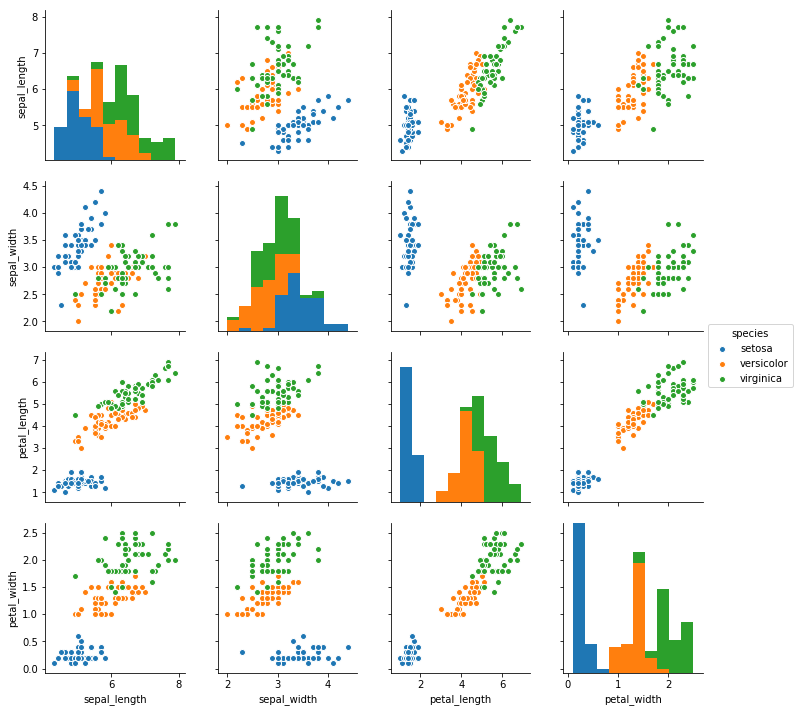

In [369]:
sns.pairplot(iris, hue='species')

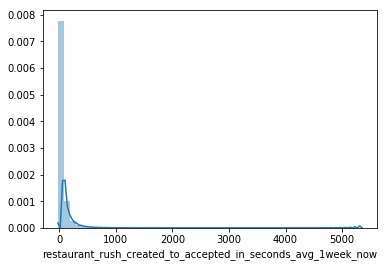

In [293]:
sns.distplot(train_compress['restaurant_rush_created_to_accepted_in_seconds_avg_1week_now'])

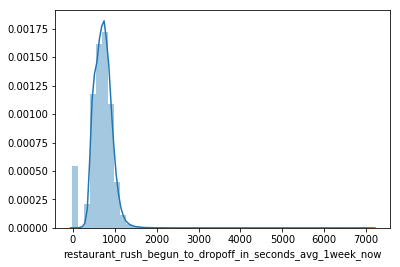

In [311]:
sns.distplot(train_compress['restaurant_rush_begun_to_dropoff_in_seconds_avg_1week_now'])

In [97]:
prediction_cols = [
    'predict',
    'false',
    'true',
    'predictedindexedlabel',
    'indexedlabel',
    'indexed_ti_workflowcreatedat_local_day_of_week',
    'indexed_restaurant_fast_food',
    'indexed_restaurant_country_name',
    'indexed_restaurant_city_name',
    'indexed_restaurant_uuid',
    'indexed_restaurant_parent_chain',
    'indexed_restaurant_cuisine']
    
train.drop(prediction_cols, axis=1, inplace=True)
test.drop(prediction_cols, axis=1, inplace=True)
    
print("Train, test and validation sets")
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')
            
print(train.shape)
print(test.shape)
print("Processed dataset...")
    
X_train = train.drop(['target'], axis=1)
y_train = train['target'].values

print(X_train.info())

gc.collect()
    
# Train & test split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)
    
print("Training set size: ", len(y_tr))
print("Validation set size: ", len(y_val))
print("# and % of positive labels in training set", sum(y_tr), sum(y_tr)/float(len(y_tr)))
print("# and % of positive labels in validation set", sum(y_val), sum(y_val)/float(len(y_val)))
    
X_test = test.drop(['target'], axis=1)
y_test = test['target'].values

(4181252, 80)
(4373603, 80)
Train, test and validation sets
(4181252, 68)
(4373603, 68)
Processed dataset......
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4181252 entries, 0 to 4181251
Data columns (total 67 columns):
restaurant_rush_created_to_accepted_in_seconds_avg_1week_now                      float64
restaurant_rush_begun_to_dropoff_in_seconds_avg_1week_now                         float64
restaurant_order_created_to_accepted_in_seconds_avg_1week_now                     float64
restaurant_rush_accepted_to_begun_in_seconds_avg_1week_now                        float64
restaurant_order_accepted_to_finished_in_seconds_avg_1week_now                    float64
restaurant_order_created_to_rush_begun_in_seconds_avg_1week_now                   float64
restaurant_order_count_1week_now                                                  float64
restaurant_order_created_to_rush_begun_in_seconds_avg_1week                       float64
restaurant_rush_accepted_to_begun_in_seconds_avg_1week 

In [127]:
train.shape

(4181252, 68)

In [128]:
train['restaurant_country_name']

0           United States
1             New Zealand
2               Singapore
3                  Canada
4            South Africa
5             New Zealand
6                  Mexico
7                Colombia
8                  Brazil
9           United States
10          United States
11          United States
12              Australia
13          United States
14          United States
15          United States
16                 France
17                 Mexico
18          United States
19          United States
20          United States
21          United States
22          United States
23                 Poland
24          United States
25          United States
26                 Mexico
27                  India
28               Thailand
29             Costa Rica
                ...      
4181222         Australia
4181223     United States
4181224            Canada
4181225     United States
4181226            France
4181227         Australia
4181228     United States
4181229     

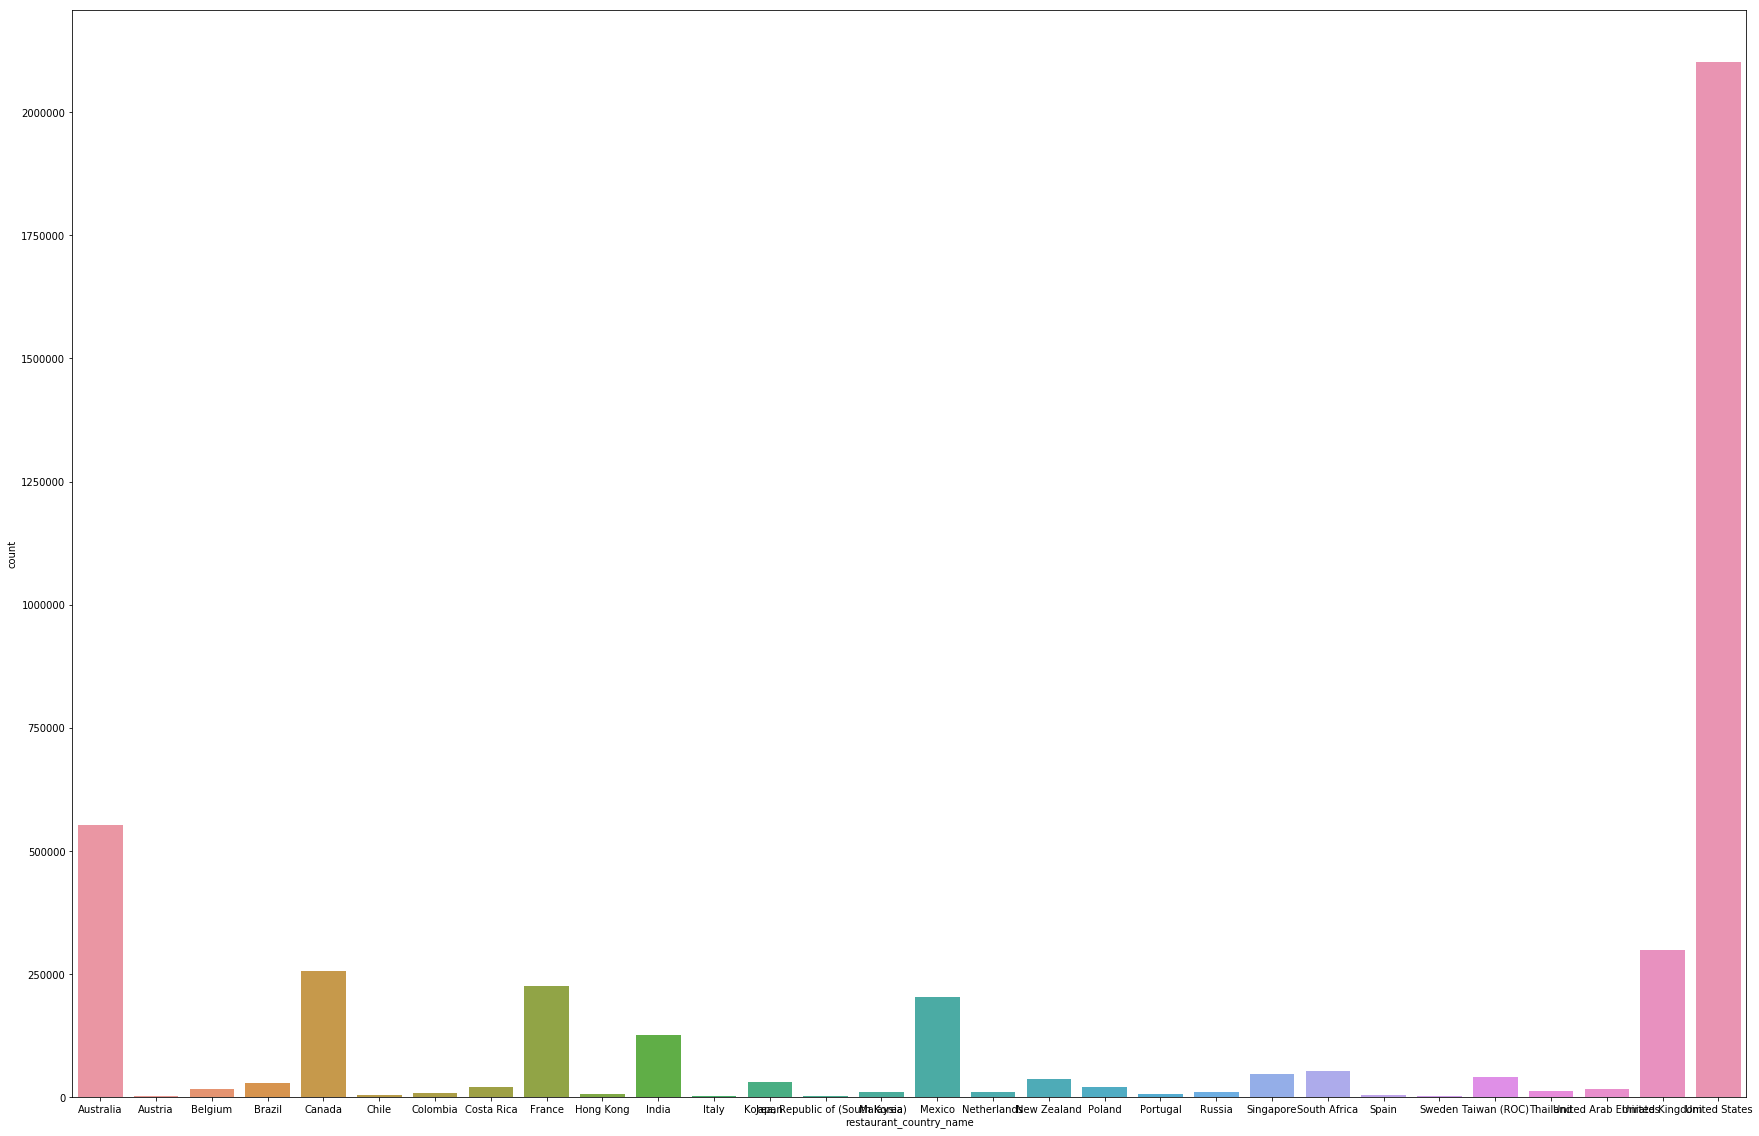

In [129]:
plt.figure(figsize=(30,20))
sns.countplot(x="restaurant_country_name", data=train)

In [130]:
train.isna().sum()

restaurant_rush_created_to_accepted_in_seconds_avg_1week_now                          0
restaurant_rush_begun_to_dropoff_in_seconds_avg_1week_now                             0
restaurant_order_created_to_accepted_in_seconds_avg_1week_now                         0
restaurant_rush_accepted_to_begun_in_seconds_avg_1week_now                            0
restaurant_order_accepted_to_finished_in_seconds_avg_1week_now                        0
restaurant_order_created_to_rush_begun_in_seconds_avg_1week_now                       0
restaurant_order_count_1week_now                                                      0
restaurant_order_created_to_rush_begun_in_seconds_avg_1week                           0
restaurant_rush_accepted_to_begun_in_seconds_avg_1week                                0
restaurant_rush_created_to_accepted_in_seconds_avg_1week                              0
restaurant_rush_begun_to_dropoff_in_seconds_avg_1week                                 0
restaurant_order_created_to_acce

In [138]:
train.drop(['restaurant_country_name', 'restaurant_city_name',
                              'ti_workflowcreatedat_local_day_of_week', 'restaurant_uuid',
                              'restaurant_parent_chain', 'restaurant_cuisine'], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4181252 entries, 0 to 4181251
Data columns (total 62 columns):
restaurant_rush_created_to_accepted_in_seconds_avg_1week_now                      float64
restaurant_rush_begun_to_dropoff_in_seconds_avg_1week_now                         float64
restaurant_order_created_to_accepted_in_seconds_avg_1week_now                     float64
restaurant_rush_accepted_to_begun_in_seconds_avg_1week_now                        float64
restaurant_order_accepted_to_finished_in_seconds_avg_1week_now                    float64
restaurant_order_created_to_rush_begun_in_seconds_avg_1week_now                   float64
restaurant_order_count_1week_now                                                  float64
restaurant_order_created_to_rush_begun_in_seconds_avg_1week                       float64
restaurant_rush_accepted_to_begun_in_seconds_avg_1week                            float64
restaurant_rush_created_to_accepted_in_seconds_avg_1week                     

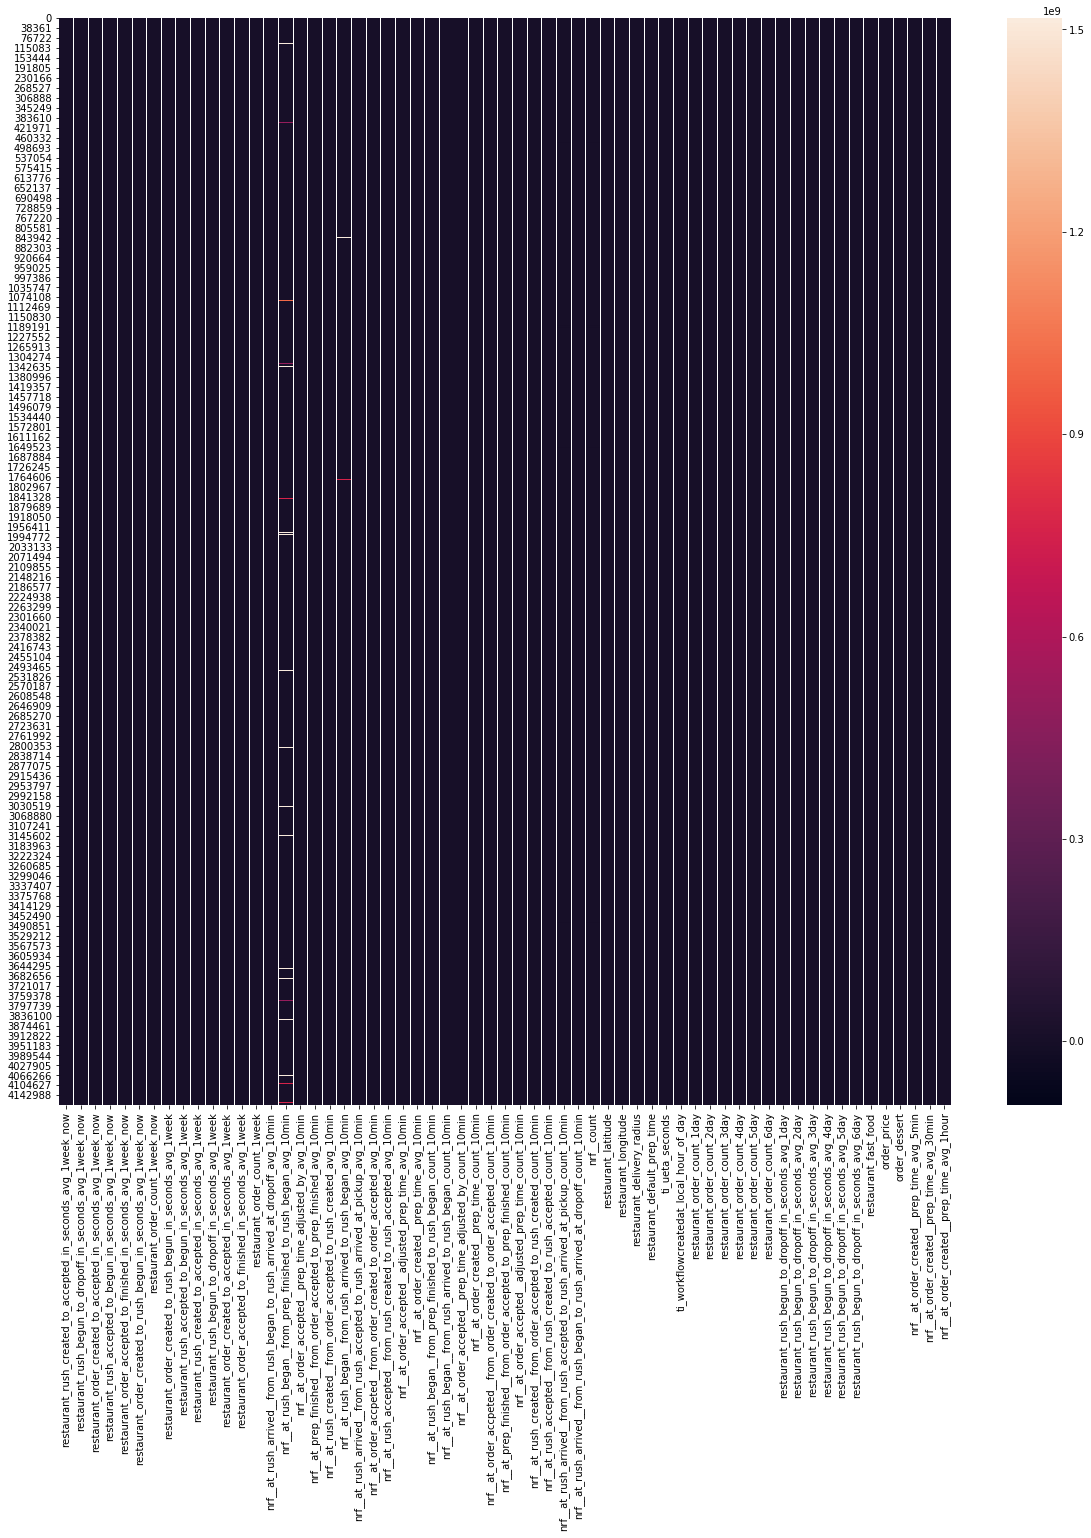

In [141]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(train.drop(['restaurant_country_name', 'restaurant_city_name',
                              'ti_workflowcreatedat_local_day_of_week', 'restaurant_uuid',
                              'restaurant_parent_chain', 'restaurant_cuisine', 'target'], axis=1))

In [98]:
# Modeling
lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_val = lgb.Dataset(X_val, y_val)

params = {
 'objective': 'binary',
 'boosting': 'gbdt',
 'learning_rate': 0.1,
 'verbose': 0,
 'max_depth': 8,
 'num_leaves': 100,
 'bagging_fraction': 0.95,
 'bagging_freq': 1,
 'bagging_seed': 1,
 'feature_fraction': 0.9,
 'feature_fraction_seed': 1,
 'max_bin': 256,
 'metric': 'auc'
}
    
lgbm_model = train_lgbm_model(params, lgb_train, lgb_val)

Starting to train LightGBM model......
{'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'verbose': 0, 'max_depth': 8, 'num_leaves': 100, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'bagging_seed': 1, 'feature_fraction': 0.9, 'feature_fraction_seed': 1, 'max_bin': 256, 'metric': 'auc'}


/Users/allen/python3-env/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[5]	valid_0's auc: 0.857451
[10]	valid_0's auc: 0.860762
[15]	valid_0's auc: 0.861955
[20]	valid_0's auc: 0.863597
[25]	valid_0's auc: 0.865116
[30]	valid_0's auc: 0.86647
[35]	valid_0's auc: 0.867754
[40]	valid_0's auc: 0.869383
[45]	valid_0's auc: 0.87047
[50]	valid_0's auc: 0.87133
[55]	valid_0's auc: 0.871886
[60]	valid_0's auc: 0.872315
[65]	valid_0's auc: 0.872796
[70]	valid_0's auc: 0.87317
[75]	valid_0's auc: 0.873393
[80]	valid_0's auc: 0.873629
[85]	valid_0's auc: 0.874034
[90]	valid_0's auc: 0.874283
[95]	valid_0's auc: 0.874437
[100]	valid_0's auc: 0.874543
[105]	valid_0's auc: 0.874763
[110]	valid_0's auc: 0.87487
[115]	valid_0's auc: 0.875029
[120]	valid_0's auc: 0.875161
[125]	valid_0's auc: 0.875261
[130]	valid_0's auc: 0.875373
[135]	valid_0's auc: 0.875627
[140]	valid_0's auc: 0.875693
[145]	valid_0's auc: 0.875761
[150]	valid_0's auc: 0.875853
[155]	valid_0's auc: 0.875944
[160]	valid_0's auc: 0.875996
[16

In [100]:
# Make predictions
print('Predicitng on test set...')
y_hat_test = lgbm_model.predict(X_test)

Predicitng on test set...


In [99]:
# Calculate AUC
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test).astype(int), np.array(y_hat_test))
    
print('FPR: {}'.format(fpr))
print('TPR: {}'.format(tpr))
print('AUC: {}'.format(metrics.auc(fpr, tpr)))
    
print_importance(lgbm_model)

FPR: [  0.00000000e+00   2.57622801e-07   7.72868403e-07 ...,   9.99987892e-01
   9.99988407e-01   1.00000000e+00]
TPR: [ 0.  0.  0. ...,  1.  1.  1.]
AUC: 0.8481866605812072
--- Feature importance with 'gain' measure ---
                                              feature       gain  split
28       nrf__at_order_created__prep_time_count_10min  20.275731    900
59                            restaurant_parent_chain  16.644044   2637
42                               restaurant_city_name  14.590429   1781
58                                    restaurant_uuid  11.746306   9833
36                                         nrf__count   4.835809   3055
13                       restaurant_order_count_1week   3.493269   1990
31  nrf__at_order_accepted__adjusted_prep_time_cou...   2.781874     60
43                                    ti_ueta_seconds   2.246415   6803
46                        restaurant_order_count_1day   1.960838   2610
44             ti_workflowcreatedat_local_hour_of_day   1.

In [ ]:
# dump model with pickle
with open(MODEL_PATH, 'wb') as fout:
    pickle.dump(lgbm_model, fout)
    
# load model with pickle to predict
with open(MODEL_PATH, 'rb') as fin:
    pkl_bst = pickle.load(fin)